<font face="Times New Roman">
<div dir=ltr align=center>
<font color=3C99D size=5>
    Support Vector Machines

# Packages

In [204]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv("Liver_Disease.csv") 

### Pre-Processing

#### Exploratory Data Analysis (EDA):
In statistics, exploratory data analysis is an approach to analyze datasets to summarize their main characteristics, often using statistical graphics and other data visualization methods.

This is a general approach that should be applied when you encounter a dataset.

Shape of data (583, 11)

Missing values:
 Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
label                         0
dtype: int64

Labels:
 label
1    416
2    167
Name: label, dtype: int64



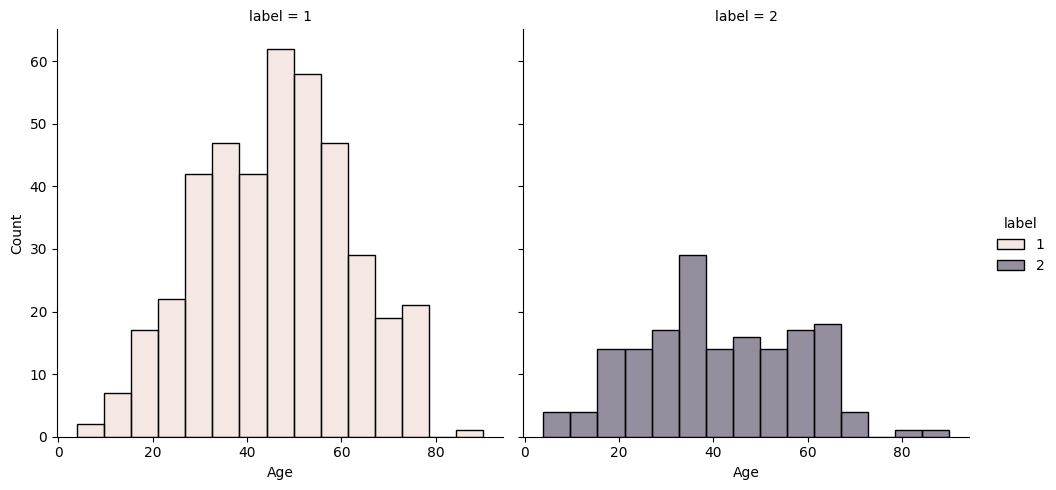

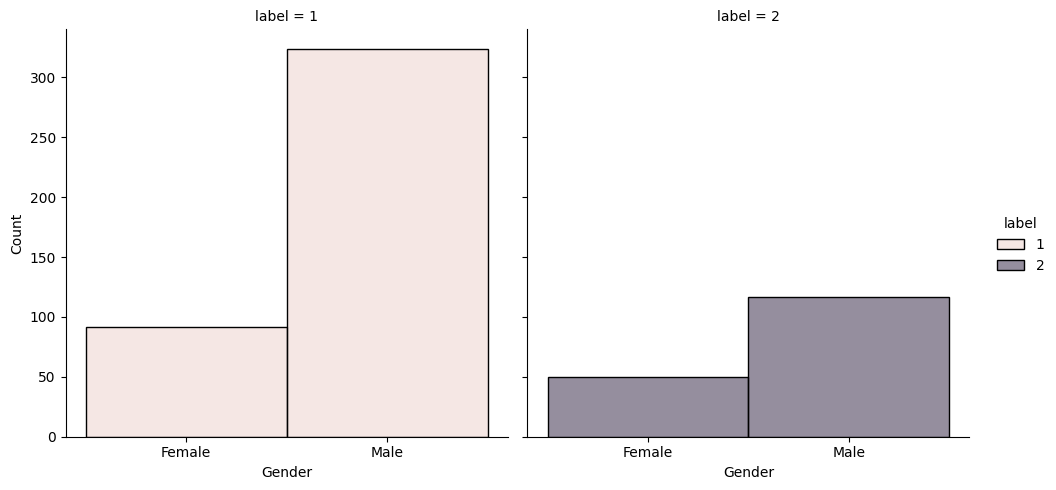

In [64]:
print("Shape of data", df.shape)
print()
print("Missing values:\n %s" % df.isnull().sum())
print()
print('Labels:\n', df.groupby('label')['label'].count())
## we can see that the dataset is not balance
print()
sns.displot(df, x="Age", hue="label", col="label")
sns.displot(df, x="Gender", hue="label", col="label")

For lable `1` we have normal Age distribution and we have peak around 5, but for label `2` we can see distribution has a peak around 38. Gender distribution is almost the same for both labels.

#### Outlier Detection & Removal

In [89]:
print(df.shape)
for c in df.columns:
  if c != 'label' and df.dtypes[c] != 'object':
    mean = df[c].mean()
    std = df[c].std()
    df = df[df[c].between((mean - 3*std), (mean + 3*std))]
print(df.shape)

(436, 11)
(384, 11)


#### Feature Engineering:

In [96]:
numerical = []
for i, t in enumerate(df.dtypes):
  if t != 'object' and df.columns[i] != 'label':
    numerical.append(df.columns[i])

scaler = MinMaxScaler()
df.loc[:, numerical] = scaler.fit_transform(df.loc[:, numerical])

### SVM

In [106]:
encoder = LabelEncoder()
df['Gender'] = encoder.fit_transform(df['Gender'])

#### spliting data

In [108]:
y = 'label'
X = df.loc[:, df.columns != y].columns
X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], random_state=0)

### SVM using Scikit-Learn:

In [127]:
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: %s" % accuracy)
print("F1-score: %s" % (f1))

Accuracy: 0.6354166666666666
F1-score: 0.7651006711409395


#### Grid Search

In [129]:
model = SVC()
params = {
    'C': [0.1, 1, 10, 80],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
    'decision_function_shape': ['ovo', 'ovr']
}

cv = RepeatedKFold(n_splits=10, random_state=0)

search = GridSearchCV(model, params, scoring='accuracy', n_jobs=-1, cv=cv)

result = search.fit(X_train, y_train)

print('Best Score:', result.best_score_)
print('Best Hyperparameters:', result.best_params_)

Best Score: 0.5971921182266009
Best Hyperparameters: {'C': 0.1, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'rbf'}


In [130]:
model = SVC(C=0.1, decision_function_shape='ovo')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

### Confusion Matrix

Accuracy: 0.625


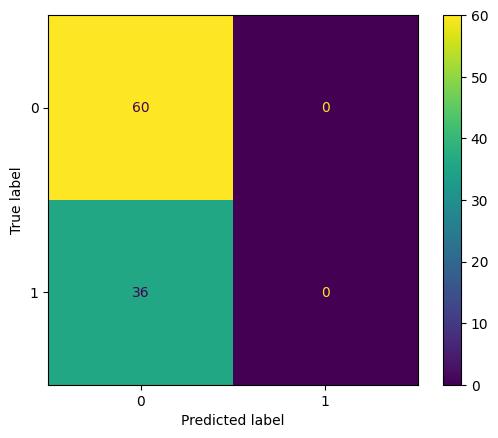

In [131]:
print("Accuracy: %s" % accuracy)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot()
plt.show()

In [227]:
## Adding 30 samples that are noise (10% of data)
noise1 = abs(np.random.normal(2, 0.1, 15*9))
noise2 = abs(np.random.normal(0, 0.01, 15*9))

noise = np.append(noise1, noise2)

noisy_x = X_train
cols = X_train.loc[:, X_train.columns != 'Gender'].columns
for i in range(15):
  noise_entry = dict()
  for j, c in enumerate(cols):
    noise_entry[c] = noise[j + (i*9)]
  noise_entry['Gender'] = random.randint(0, 1)
  noisy_x = pd.concat([noisy_x, pd.DataFrame(noise_entry, index=[0])], ignore_index=True)

temp = [random.randint(0, 1) for _ in range(15)]
noisy_y = pd.concat([y_train, pd.Series(temp)])

numerical = []
for i, t in enumerate(df.dtypes):
  if t != 'object' and df.columns[i] != 'label':
    numerical.append(df.columns[i])

In [229]:
model = SVC()
model.fit(noisy_x, noisy_y)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("SVM accuracy: %s" % accuracy)

model = LogisticRegression()
model.fit(noisy_x, noisy_y)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("LogisticRegression accuracy: %s" % accuracy)

SVM accuracy: 0.625
LogisticRegression accuracy: 0.6666666666666666
